# Seminar Data Science for Economics Final Assignment Combined with Kaggle Competition: House Prices - Advanced Regression Techniques
## A Comprehensive Introductory Study of Machine Learning Methods and Applications
## Weiyuan Liu, MSc Economics (2022-2023)

## Introduction
This report thoroughly investigates a dataset sourced from one of the most renowned online machine learning competitions, Kaggle, and explore machine learning techniques, including unsupervised learning, supervised learning, and deep learning, with the overarching goal of achieving precise predictions. The competition, titled "House Prices - Advanced Regression Techniques," (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) serves as the foundation for this study. The competition's singular objective is to increase model accuracy - minimizing the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the target. This objective aligns with the definition of the focus of the applied predictive modeling - to optimize prediction accuracy (Kuhn & Johnson, p. 1, 2013). The majority of the models learnt from our course are categorized as this type, except for the Bayesian Models, which extend toward causal analysis. Therefore I decide to exclude the Bayesian Models from this study. This report is structured into three primary sections.
  
First, the report unveils a comprehensive sequence of steps encompassing exploratory data analysis (EDA), rigorous data cleaning procedures, and meticulous data preparation for model implementation. The EDA primarily focuses on data visualization, presenting the distribution of the target variable, panels of the distributions of the numerical variables, and a correlation diagram. The data cleaning procedures address several critical aspects, inlcuding ensuring the uniformity of variables, the identification of missing values, imputing missing values and filling missing values. Data preparation involves two key transformations: the normalization of the numerical variables and one hot encoding of categorical variables. Both supervised and unsupervised learning methodologies have already been implemented at this stage. Filling missing numeric values incorporates a K-Nearest Neighbors (KNN) model, and the illustration of interactions among numeric and categorical variables utilizes t-Distributed Stochastic Neighbor Embedding (t-SNE) to generate intuitive plots.
  
Second, the report presents the construction of an array of supervized learning models, beginning with five basic learners, K-Nearest Neighbors (KNN), Ridge, Lasso, Support Vector Machine (SVM) and Decision Tree, followed by two widely-acknowledged and powerful ensemble learning techniques, Random Forest (RF) and Extreme Gradient Boosting (XGBoost). Upon completing the initial assessment of model performance, Ridge, RF and XGBoost are selected for hyperparameter tunning to improve their predictive capabilities. The section concludes with evaluation and comparison of the three selected models, and a detailed examination of feature importances from extracted from XGBoost.
  
Third, the report introduces a deep learning model, utilizing Neural Networks to enhance predictive accuracy. Concluding this report, the predictions generated by the chosen Ridge model, Random Forest model, XGBoost model, and Neural Networks model are subjected to competition. The ultimate scores, alongside the pinnacle position attained on the competition leaderboard, are presented at the end.

### Choice of the Dataset
Nevertheless, the assignment suggests us to create a dataset from an economic organization. This report deviates from economic data. I choose this dataset in consideration that the dataset is clearly task oriented, and variables are generated from the same underlying data generate process. Usually, a macroeconomic model is required when we need to know which variables to collect. Randomly gathering data from websites resembles data dredging, and simply increases the risk of false positives.

Economic data are mostly time series. I avoid time series because they are very difficult. First, the train-test-split is different for time series. You can't use more recent data to predict the past data, therefore in evaluation procedures such as cross validation, a standard way is that whenever a fold is finished, data in the subsequent period are added to make the next fold, which sophisticates complexity. Second, some important economic datasets are small. For example, some countries publish GDP growth rates, or, unemployment rates, on monthly or quarterly basis. Even with a time span of twenty years, there are less than a hundred records, let alone general economic conditions progress so swiftly that data from five or ten years ago have much less implications for the present and future (for example, quatitative easing era displays much different trends than pre financial crisis era). In general, predictive modelling favors more data.
  
Moreover, time series exhibit correlations, but not necessarily causations, and it usually requires considerably more time to investigate if desired. Quoting an example from _The effect: An introduction to research design and causality_ (Huntington-Klein, 2021, chapter 6.1), there are more people wearing shorts when people eat more ice cream, but the first phenomenon does not tend to cause the second phenomenon. This complexity would exert much difficulty on the analysis that might raise questions on the preditive power of features. For example, the Phillips curve suggests a relationship between unemployment rates and inflation rates, However, the correlations and causal relationships underlying this proposition have remained subjects of persistent debate. Despite theoretical considerations, each point I mention above really necessitates substantial amount of time applying statistician, econometrician and programming techniques to check and validate (they are economists' job, anyways). To circumvent those issues while showcasing my programming skills and understanding of machine learning and deep learning, my selection of dataset is a very good choice. Other good choices can be datasets from UC Ivrine, MNIST, etc.

In [24]:
# Interacting with API is data scientists' way of getting data. However, to download data, a token (json file) with account information is required. I've already expired the token. Datasets are provided when submitting the assignment.

# !pip install kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 /home/repl/.kaggle/kaggle.json
# !~/.local/bin/kaggle competitions download -c house-prices-advanced-regression-techniques
# !unzip house-prices-advanced-regression-techniques.zip

In [25]:
# Searching avaliable files in the directory and display file names
import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\data_description.txt
.\house-prices-advanced-regression-techniques.zip
.\keras.csv
.\notebook.ipynb
.\RF.csv
.\Ridge.csv
.\sample_submission.csv
.\Screenshot 2023-08-15 202435.jpg
.\test.csv
.\train.csv
.\XGB.csv
.\.jupyter\lab\workspaces\default-37a8.jupyterlab-workspace


In [26]:
# !pip install xgboost

In [27]:
# !pip install tensorflow

In [28]:
# This report uses scikit learn and xgboost for preprocessing data, train-test-split, and building machine learning models, Keras for deep learning, seaborn and plotly for visualization

# !pip install plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
import plotly.express as px

In [29]:
# Macros for plot
%matplotlib inline
sns.set_theme(style = 'darkgrid',palette='bright')

### Data
There are two datasets. The training dataset have features and a target, and the test dataset only have features. The competition requires to build models on train dataset, and make predictions on test dataset, then submit them. Predictions are compared with unseen data on the server, and that's how scores are calculated.
  
Features are house characteristics such as area in squared feet, house type, house conditions, etc. The target variable is sale price. Models should utilize house characteristics to produce accurate predictions on sale price. The datasets consist of two types of data, numeric data and string data. Numeric data include continuous values such as area, and discrete values such as ratings and year. String data are basically categorical variables. 
  
The training dataset has shape 1460 by 80, and the test dataset has shape 1459 by 79 (because it doesn't have the target variable). This is a workable size on the university's 16GB RAM and 8vCPU cloud computing plantform. However, some programs are still very slow, such as simulations. Datasets with larger sizes can be worked with Pyspark, however, that is out of the scope of this report and the assignment.

In [30]:
train = pd.read_csv('./train.csv', index_col='Id')
test = pd.read_csv('./test.csv',index_col='Id')
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

## Exploratory Data Analysis and Data Preparation
As Andrew Ng clarifies, "_Coming up with features is difficult, time-consuming, and requires expert knowledge. ‘Applied machine learning’ is basically feature engineering_". Preveiling views on the internet suggest data scientist spend 80% of the time on data preparation. Undeniably, I would confess that is the case in this report. I roughly estimate I spent more than 50% of the time on data visualization (part of EDA) and cleaning and shaping data. The latter is also called preprocessing or feature engineering. This process is indispensable since it addresses the need of alleviating issues such as curse of dimensionality. Furthermore, it turns out this is the most crucial part for improving model performance. Readers may find there are just a few code blocks, but they are cleaned, tidied and concentrated for presentation of efficient Python codes. The final results based on the current scheme of feature engineering are better than the early generations. However, these's still much space to improve. I saw a group that improved the feature extraction techniques from another group have a better score than my best score even from their first generation that is just a simple Random Forest with default parameter settings. However, it should be clearly understood that feature engineering entails a lot of effort and task specific knowledge and characterizes diminishing returns. Given the scope of this assignment, this criterion is fullfilled more than satisfactory.
  
In my view, data visulization is very important for data scientists. I also spent a lot of time creating illustrative and good looking graphs.

In [31]:
# All columns until the last one are features (X variables). The last column is the target (y variable).
feature = train.iloc[:,:-1]
target = train.iloc[:,-1]
target = np.log(target)
Combined_data = pd.concat([feature,test],axis = 0) # I combine two datasets so I can preprocess them simutaneously

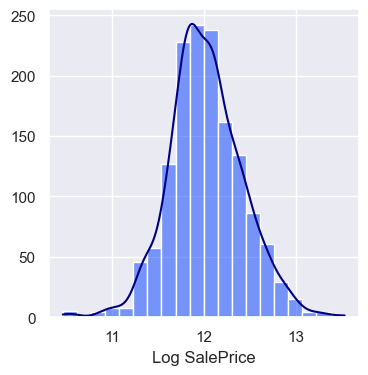

In [32]:
# Visulization of the target variable, a histogram and a kernel density estimate
fig,ax = plt.subplots(figsize = (4,4))
sns.histplot(x=target,bins = 20,ax= ax,kde=True).set(ylabel = None, xlabel = 'Log SalePrice')
ax.lines[0].set_color('navy')
plt.show()

In [33]:
# Using pandas methods to select numeric variables, string variables and missing values
numeric = Combined_data.select_dtypes('number').columns
print('Number of numeric columns is {}'.format(numeric.shape[0]),'\n')
missing_num = Combined_data[numeric].isna().sum()
print('There are {} columns with missing values. Columns with missing values and number of missing values are:\n{}'.format(len(missing_num[missing_num > 0]),missing_num[missing_num > 0]),'\n')
missing_num_names = missing_num[missing_num > 0].keys()

strings = Combined_data.select_dtypes('object').columns
print('Number of string columns is {}'.format(strings.shape[0]),'\n')
missing_str = Combined_data[strings].isna().sum()
print('There are {} columns with missing values. Columns with missing values and number of missing values are:\n{}'.format(len(missing_str[missing_str > 0]),missing_str[missing_str > 0]))

Number of numeric columns is 36 

There are 11 columns with missing values. Columns with missing values and number of missing values are:
LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64 

Number of string columns is 43 

There are 23 columns with missing values. Columns with missing values and number of missing values are:
MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: 

In [34]:
# Here I define a function to plot the panel (4 by 9 histograms) below, because I need to plot this panel twice
def EDA_4by9_graph(features):
    fig, axes = plt.subplots(4,9,figsize=(24,8))
    axes = axes.flatten() # To create a mapping from multidimensional axes objects to one dimensional. If I explain this, I also have to explain to fig and axes objects above (which is different from the simple plotting procedure taught in the lecture), then I also have to explain object oriented programming in Python. I assume readers (graders) understand it
    for i, value in enumerate(numeric):
        ax = sns.histplot(x=features[value], ax=axes[i], bins=20, kde=True)
        ax.set_ylabel(None)
        ax.lines[0].set_color('navy')
    fig.text(0.0,0.5,'Count',rotation='vertical',horizontalalignment='center',verticalalignment='center',fontsize = 15)
    return fig, axes

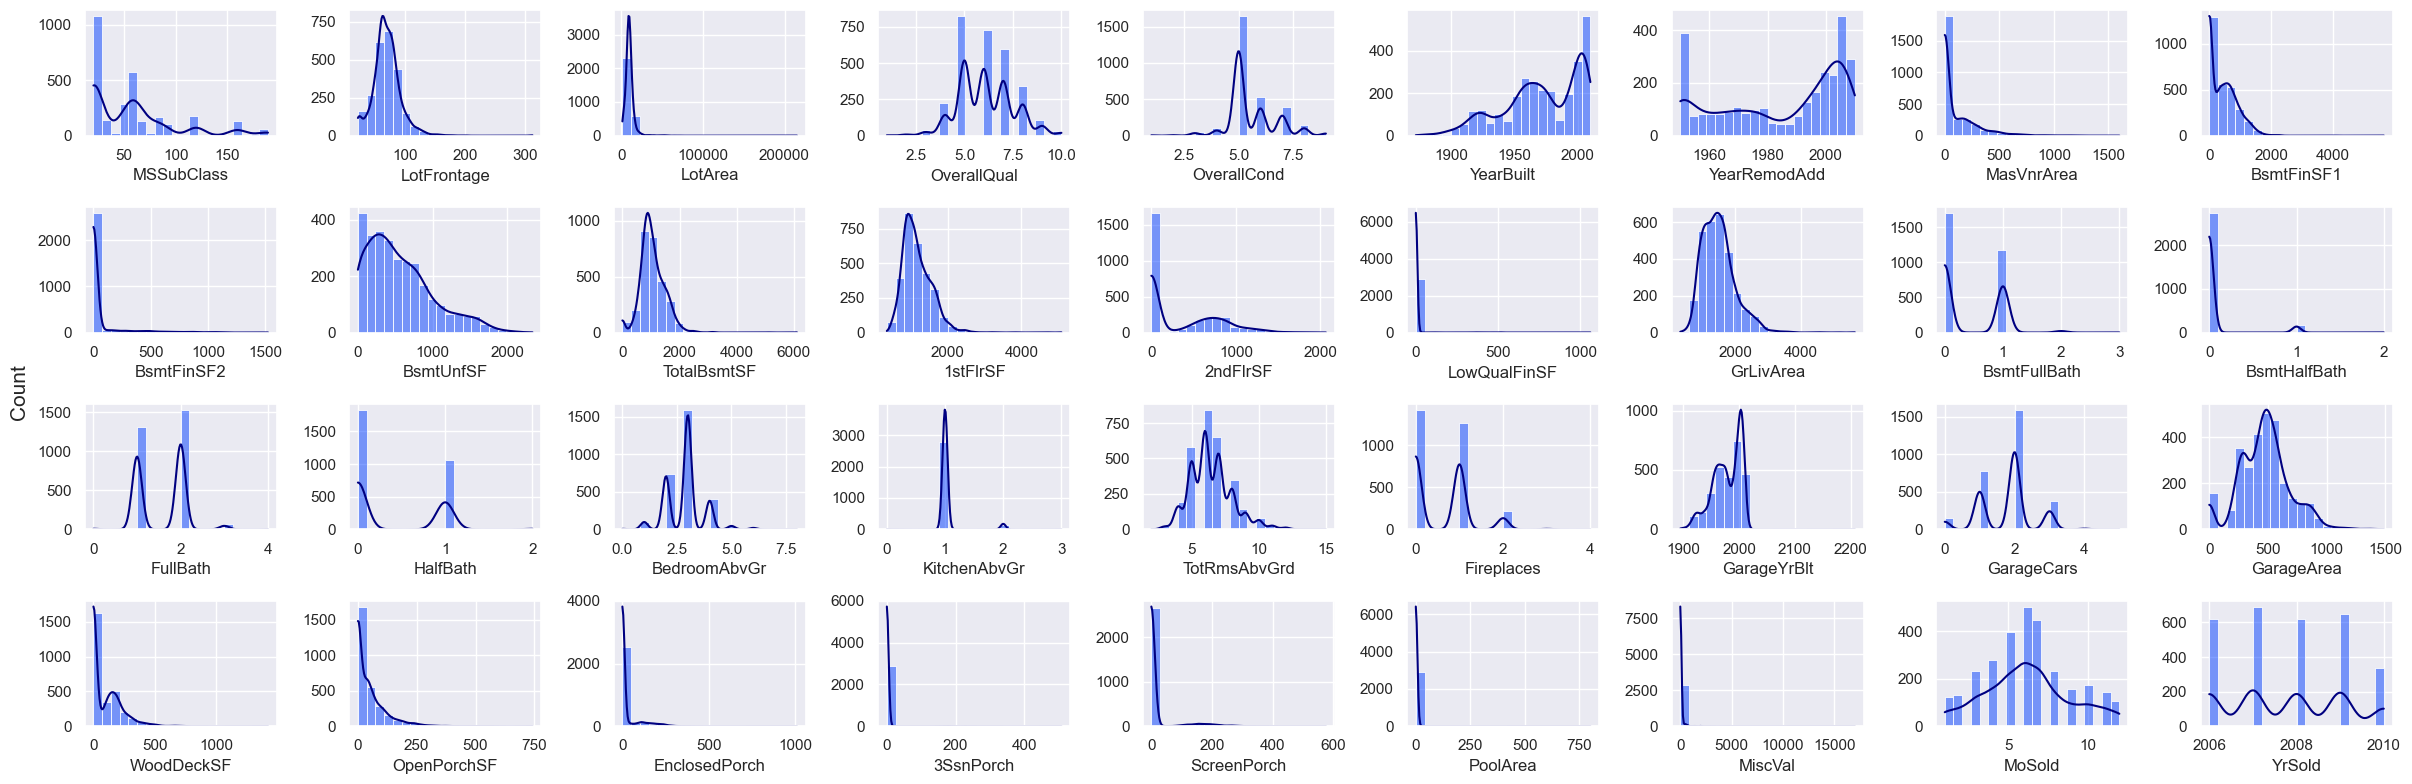

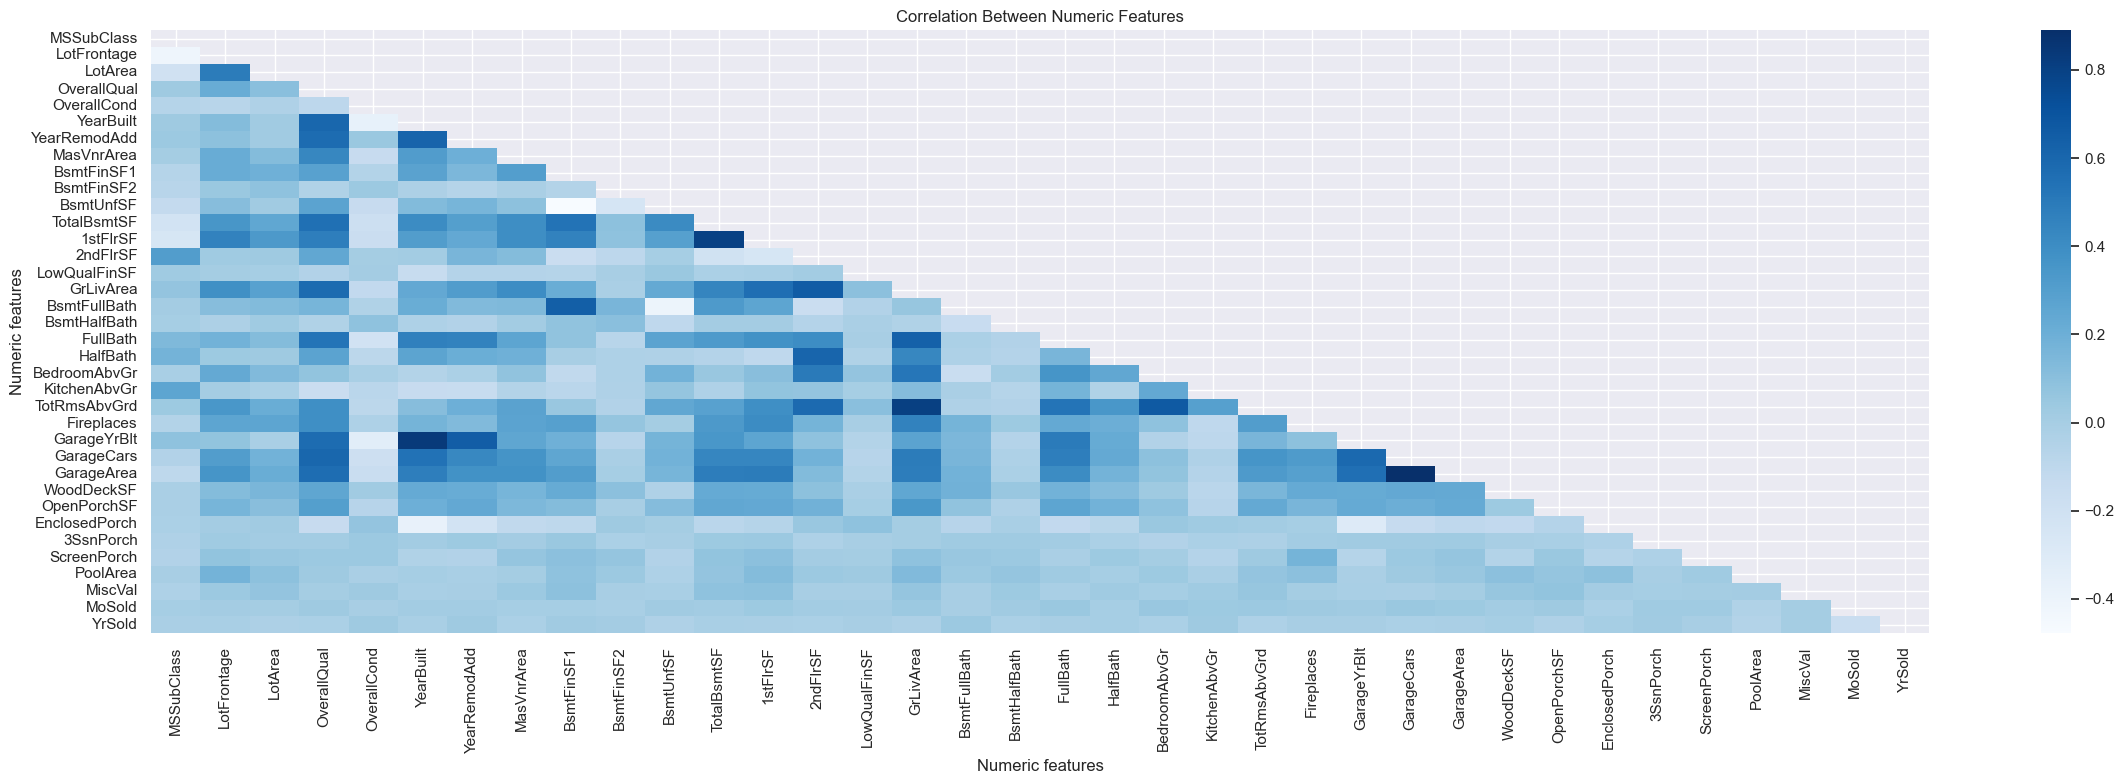

In [35]:
# EDA
fig, axes = EDA_4by9_graph(Combined_data)
plt.tight_layout()

# This is a heatmap showing correlations among numeric variables. This is a fundamental step in preprocessing, as it prepares for correlation analysis such as principal component analysis (PCA). Decorrelation is also an important part in feature engineering. I don't implement it here, because it is also time consuming.
corr = Combined_data[numeric].corr()
mask = np.triu(corr)
fig2,ax2 = plt.subplots(figsize=(24, 8))
heat = sns.heatmap(corr,annot=False,cmap = 'Blues',mask=mask, xticklabels=True, yticklabels=True,ax = ax2).set(xlabel = 'Numeric features', ylabel = 'Numeric features', title = 'Correlation Between Numeric Features')
plt.tight_layout()

plt.show()

### Data Preprocessing: Task Specific Missing Value Imputation and Numeric Variable Normalization
After examining missing variables in data_description one by one, I see there are two groups of categorical variables. The first group of variables have a category, '_None_', which simply means the house does not equip that amenity, such as garage, basement, swimming pool, etc, and they are recorded as missing values. These missing values are simply filled with 'None'. The second group of variables have missing values without any reason or description, and they don't appear to be many. I fill them with most frequent values in the corresponding columns.
  
Numeric variables are imputed by implementing K-Nearest Neighbors (KNN) Imputation. KNN is a machine learning algorithm that predicts the class or value of a new data point based on the majority class or average value of its closest labeled neighbors in the feature space. It is typically used in classification tasks. You simply give a 'k' parameter, and the algorithm will classify a point in the neigborhood of k nearest points as the same type of these points because of majority voting. Standard and quick ways of imputations are filling median values or mean values, and a bit more advanced way is using regression. These are the ways taught in econometrics. However, when there are noticable proportions of missing values, artificially creating means or medians simply alter the original distributions of data, destory the data structure and create new characteritics (I've already checked in the early generations of models), while KNN creates reasonable imputation and maintains the original data distribution.

Numeric variables come with different scales. The "curse of dimensionality" suggests althought models favor more data, when working with high-dimensional data, they often lead to increased computational complexity, sparsity, and difficulties in analysis and interpretation. For exmaple, garage cars (number of cars can be stored in the garage), area and years have substantially different scales, which deteriorates model performance. They are normalized to resemble standard normal distribution.

In [36]:
X = Combined_data.copy() # Make a copy of the dataset, such that I can reuse unshaped data later

X['MSSubClass'] = X['MSSubClass'].astype('category') # This is a numeric variable, but essentially it's categorical. It's been converted
numeric = X.select_dtypes('number').columns # Select column names of numeric variables

imputer = KNNImputer() # Instantiate the imputer, using the scikit learn package
scaler = StandardScaler() # Instantiate the scaler to transform data to standard normal distribution, using the scikit learn package
X[numeric] = imputer.fit_transform(X[numeric]) # The function objects need to fit first, then transform
X_display = X.copy() # Creates a copy of transformed data to make a plot below
X[numeric] = scaler.fit_transform(X[numeric])

si = SimpleImputer(strategy = 'most_frequent') # Instantiate the imputer, using the scikit learn package
fill_frequent = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd','Electrical', 'KitchenQual', 'Functional','SaleType'] # These are the variables to fill frequent values
X[fill_frequent] = si.fit_transform(X[fill_frequent])
X = X.fillna('None') # They rest are filled with 'None'
X = pd.get_dummies(X) # Scikit learn does not accept strings. They are encoded as dummies variables, simply using pandas function

TypeError: Cannot setitem on a Categorical with a new category (None), set the categories first

C:\Users\jdamodhar\AppData\Local\Temp\ipykernel_42400\4212105588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_missing['indicator'] = 'With missing'; features_no_missing['indicator'] = 'Without missing'
C:\Users\jdamodhar\AppData\Local\Temp\ipykernel_42400\4212105588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_missing['indicator'] = 'With missing'; features_no_missing['indicator'] = 'Without missing'


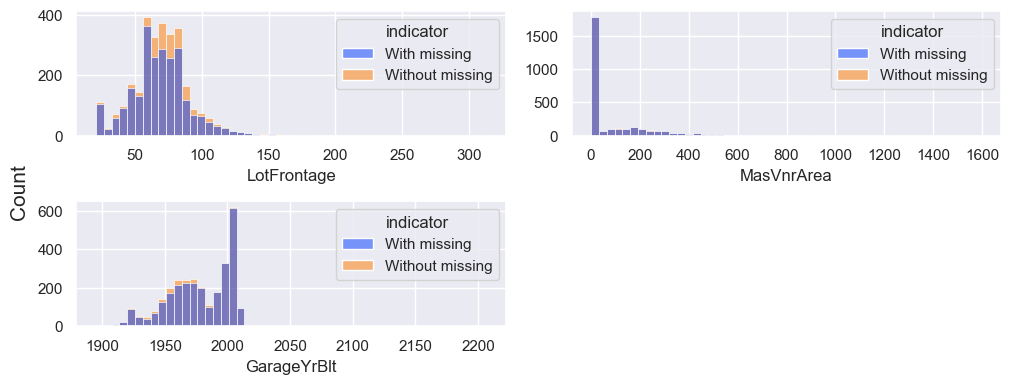

In [ ]:
# To see how reasonable KNN imputer is, I create a comparison plot. Values are created within multiple sub ranges, and shapes of distributions remain
features_missing = Combined_data[missing_num_names]
features_no_missing = X_display[missing_num_names]
features_missing['indicator'] = 'With missing'; features_no_missing['indicator'] = 'Without missing'
features_plot = pd.concat([features_missing,features_no_missing],ignore_index=True)

fig,ax = plt.subplots(2,2,figsize = (10,4))
ax = ax.flatten()
for i,value in enumerate(['LotFrontage','MasVnrArea','GarageYrBlt']):
    sns.histplot(x=value,data=features_plot,hue='indicator',ax=ax[i],bins = 50).set_ylabel(None)
ax[3].set_visible(False)
fig.text(0.0,0.5,'Count',rotation='vertical',horizontalalignment='center',verticalalignment='center',fontsize = 15)
plt.tight_layout()
plt.show()

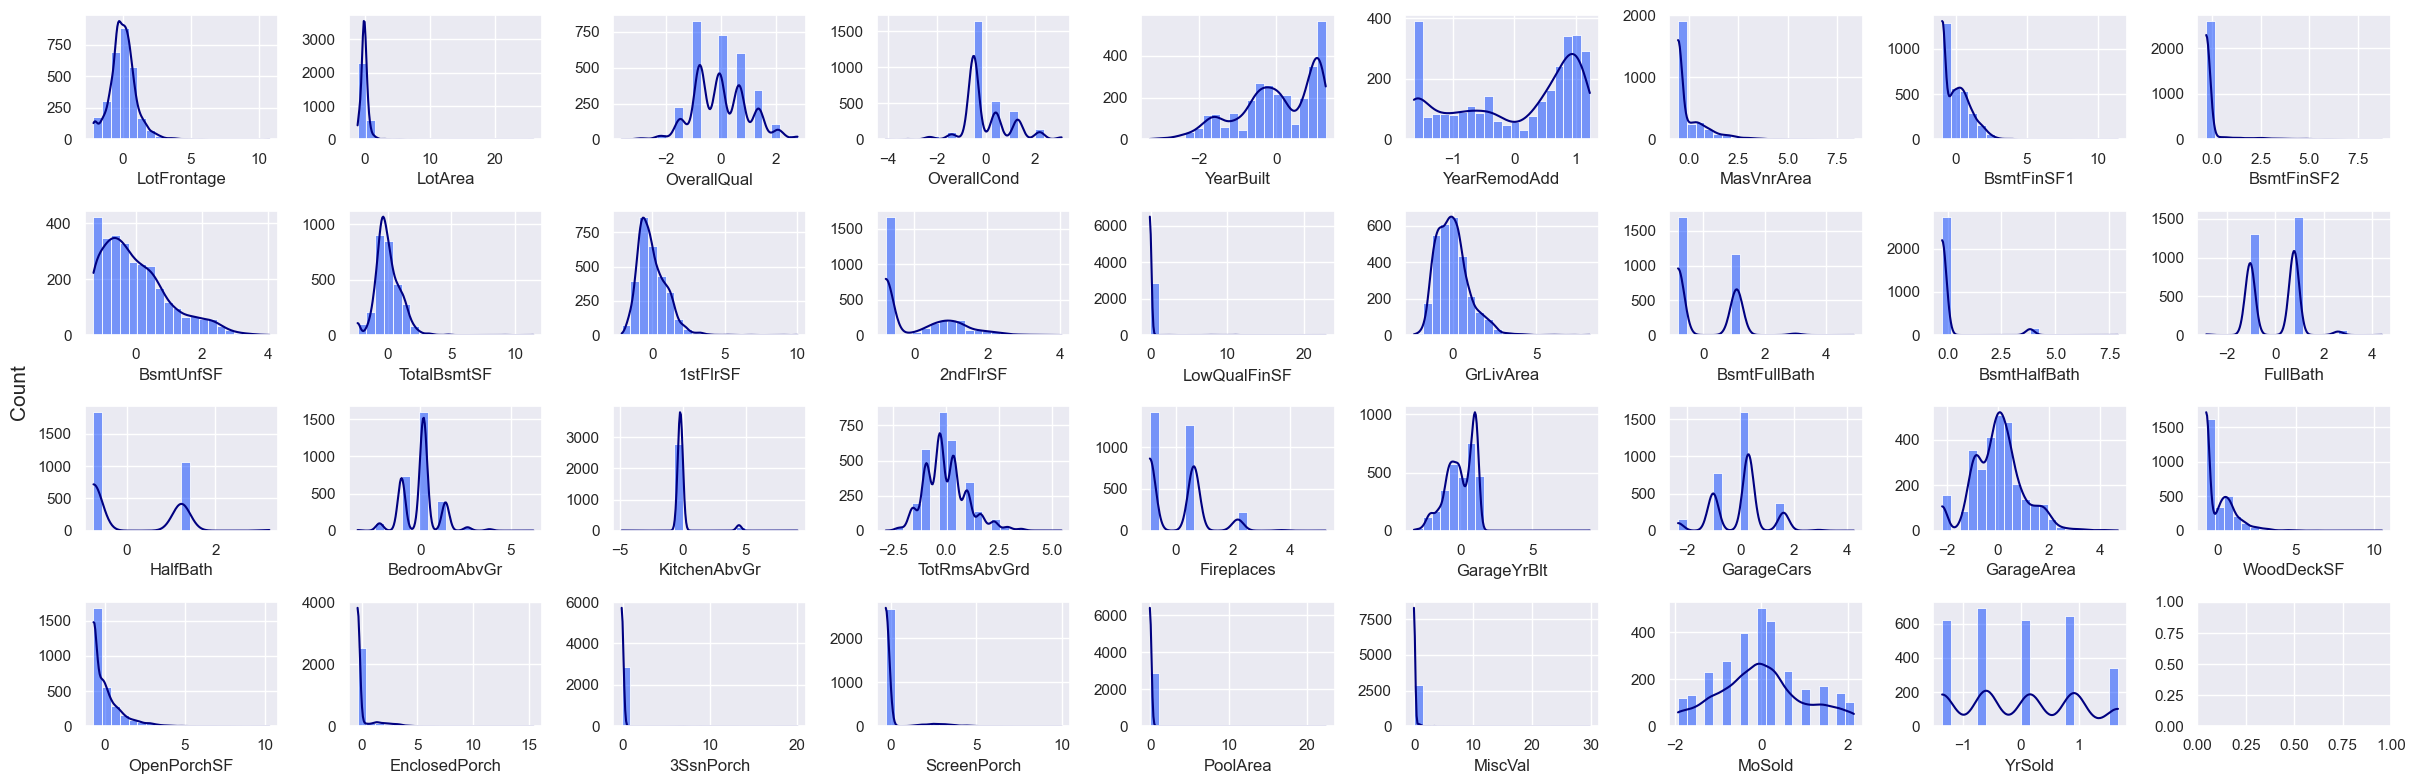

In [ ]:
# Visulization of transformed numeric variables
fig, axes = EDA_4by9_graph(X)
plt.tight_layout()
plt.show()

### Unsuperized Learning: t-Distributed Stochastic Neighbor Embedding (t-SNE)
T-Distributed Stochastic Neighbor Embedding (t-SNE) is a popular dimensionality reduction technique used in machine learning and data visualization. It simply reduces hyper dimensional data to 2D or 3D points and plots them in the corresponding spaces. It is also one of my favorite because it is very much fun, playable and very intuitive. For example, using seaborn to plot these points, at the first look I don't see something very useful. But as soon as I pass the categorical variable to aesthetic mappings, I can see that points within the same group are clustered. If passing different categorical variables, some clusters are not as concentrated as others, which might suggest lower feature importance.
  
A more fun way is using interactive plots. Plotly allows passing categorical variables to aesthetic mappings to display sub groups (similar to 'hue' in sns). Initially I wanted to pass a sequence of categorical variables to the aesthetic mappings parameter, and make a botton such that when I drag it, different plots are shown. However, the aesthetic mappings parameter does not allow that. It only allows one categorical column. A way to solve this is to manually create single frames, then combine these frames to make an animation. But it is a little beyond my ability so far. So I only creates one plotly graph, and my idea is presented as static seaborn panel plots.

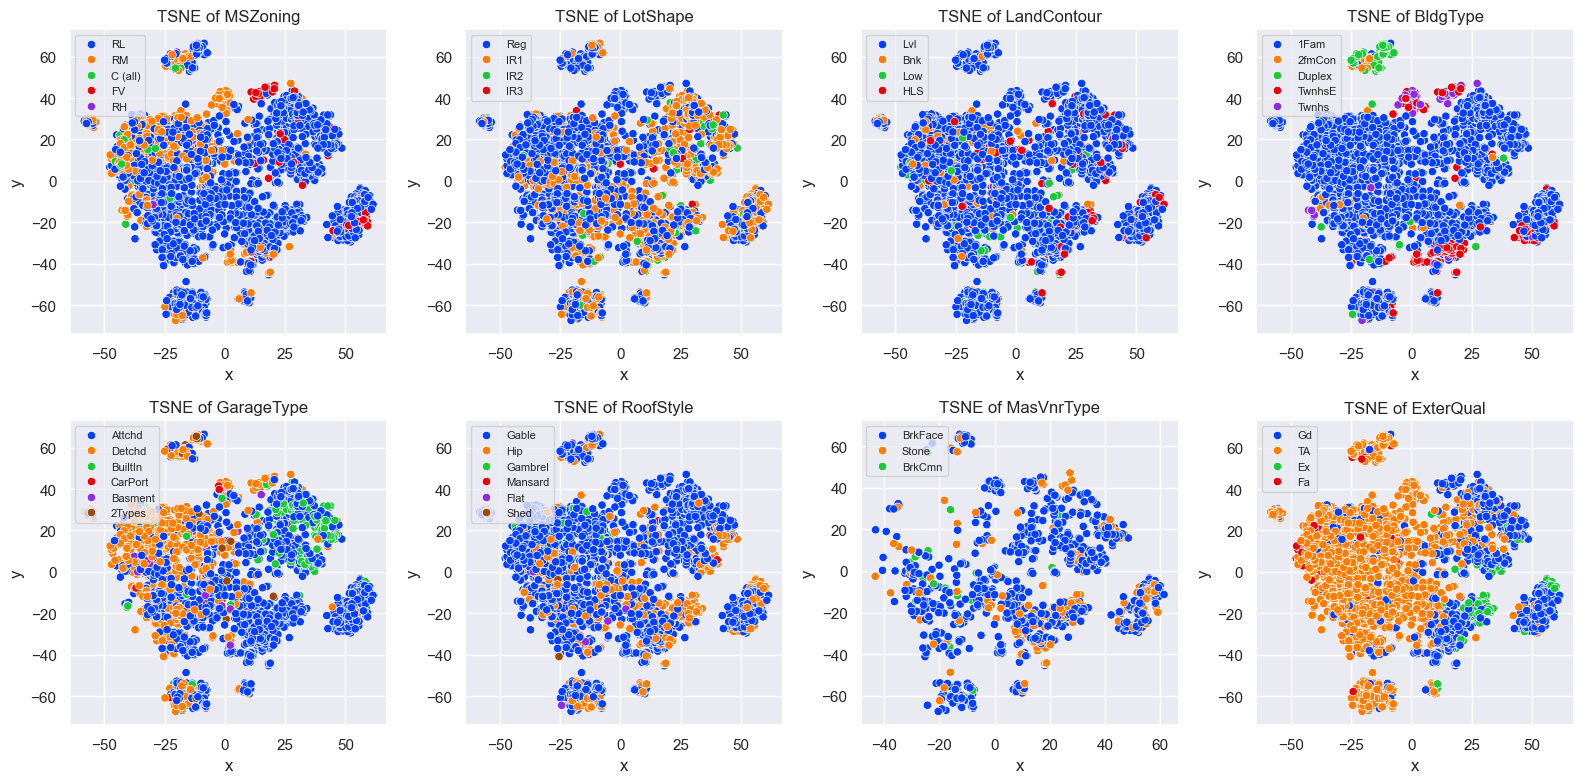

In [ ]:
# TSNE
model = TSNE(learning_rate=100,random_state= 123) # First using scikit learn to fit a model
transformed = model.fit_transform(X[numeric])
xs = transformed[:,0]
ys = transformed[:,1]
fig = px.scatter(x= xs, y=ys, color = X_display['HouseStyle']) # Using plotly to create interactive plot. You can move your cursor on the graph. The lecture suggests altair. Well, plotly is more fun
fig.update_layout(width = 500, height = 500,title_text='TSNE of HouseStyle')
fig.show()

# These are some simple data manipulations to prepare for the panel plots
features_tsne = pd.DataFrame(transformed)
features_tsne.columns = ['x','y']
features_tsne.reset_index(drop=True, inplace=True)
features_strings = X_display.select_dtypes('object')
features_strings.reset_index(drop=True, inplace=True)
features_plotly = features_tsne.merge(features_strings, left_index = True, right_index = True)

Categories_to_show = ['MSZoning','LotShape','LandContour','BldgType', 'GarageType','RoofStyle','MasVnrType','ExterQual'] # A selection of categorical variables to pass to the color parameter that display subgroups
fig, axes = plt.subplots(2,4,figsize = (16,8))
axes = axes.flatten()
for i,value in enumerate(Categories_to_show):
    ax = sns.scatterplot(data= features_plotly, x= 'x', y='y', hue = value, ax = axes[i])
    ax.legend(fontsize = 8, loc ='upper left')
    ax.set_title('TSNE of {}'.format(value))
plt.tight_layout()
plt.show()

In [ ]:
# After preprocessiong, train set and the set to produce predictions are splitted
train_data = X.iloc[:1460,:]
predict_data = X.iloc[1460:,:]
print(train_data.shape,predict_data.shape)

(1460, 79) (1459, 79)


## Supervised Learning Models and Parameter Refinement
There are seven models in this section. The first five models are basic learners, and you imediately obtain outputs as the final results. The last two are ensemble models, either of which consists of multiple basic learners and collects the results as intermediary inputs, then feed the inputs to another algorithm such as the majority voting and averaging to obtain final results.
  
KNN is introduced in the previous section. Ridge and Lasso are simply linear models plus some regularization to constrain sizes of coefficients, which are already taught in the lecture, hence no explanation needed here. Support Vector Machine (SVM) identifies an optimal hyperplane to separate data points into different classes, maximizing the margin between them. To be honest I also don't understand the method when I was learning, but since it's equipped in the scikit learn, it doesn't hurt or cost any time implementing here. Decision Tree is a popular technique in classification and regression. It involves creating a tree-like structure where each internal node represents a feature or attribute, each branch represents a decision rule, and each leaf node represents the predicted output. At each node, a question is created to divide the sample into subsamples. After several interations, the resulting subsamples represent points that share similarities, and each subsample generates unique predictions based on these similarities. Examining basic learners provides baseline model performance and preparation for model stacking and ensembling. They are advanced techniques and out of the scope of this report and assignment, but worth mentioning here.
  
Random Forest is an ensemble learning technique that constructs some decision trees during training based on bootstrapped subsamples, combining their predictions to yield a more precise and robust outcome. XGBoost is an advanced boosting algorithm that focuses on iteratively enhancing predictions by training new models that rectify the errors of preceding models. Operating within a gradient boosting framework, XGBoost concentrates on data points previously misclassified, refining its model by adjusting the weights of these inaccurately predicted points across subsequent iterations. They are genearlly more powerful and accurate than basic learners.

In [ ]:
# Standard train-test-split
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.1,random_state= 123)

In [ ]:
# Basic single learners
models = {"KNN": KNeighborsRegressor(), "Ridge": Ridge(), "Lasso": Lasso(), "SVM": SVR(), "Decision Tree": DecisionTreeRegressor(random_state= 123)}

rmse_results = []
predictions = []
for model in models.values():
    '''I iteratively fit the model and generates predictions. Here I first fit the model and store the first results. Then I do a cross validation to display distribution of model performance.'''
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    predictions.append(pred)
    
    kf = KFold(n_splits = 6, random_state= 123, shuffle = True)
    cv_results = - cross_val_score(model,X_train,y_train,cv = kf,scoring = 'neg_mean_squared_error')
    cv_results_root = np.sqrt(cv_results)
    rmse_results.append(cv_results_root)


fig,ax = plt.subplots(figsize = (10,4))
ax.boxplot(rmse_results, labels = models.keys())

fig2,axes = plt.subplots(1,5,figsize = (10,2))
for i, model_name in enumerate(models.keys()):
    ax = sns.kdeplot(predictions[i],ax = axes[i],fill = True, alpha = 0.3,label = 'Predictions')
    ax = sns.kdeplot(y_test,linewidth = 1.5, ax = axes[i], color = 'navy',label = 'True values')
    ax.set_ylabel(None)
    ax.set_xlabel(model_name)
# axes[2].set_ylim([0,1.2])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, fontsize=10,ncols = 2, loc='upper right',bbox_to_anchor=(1,1.3))
plt.show

ValueError: Input contains NaN

In [ ]:
rf = RandomForestRegressor(criterion='squared_error',random_state=123,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
rf_mse = np.sqrt(mean_squared_error(y_test,rf_pred))
print("Root Mean Squared Error (RMSE) of Random Forest on the first test:", rf_mse,'\n')

xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse',random_state=123,n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_mse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("Root Mean Squared Error (RMSE) of XGBoost on the test set:", xgb_mse)

ValueError: could not convert string to float: 'RL'

### Initial Test Performance and Model Selection for Hyperparameter Tuning
`Ridge` model is the best, and Lasso is the worst at this stage. Lasso simply predicts mean for every record. If I plot an ROC-AUC curve, it should be a straight 45 degree line. Ensemble model already gives better performance on the first test. 

Now tune some hyperparameters to boost performance. A standard way is to use GridSearch or RandomSearch. However, since this is regression, metrics might converge to a steady state, and these algorithms might produce very high values of hyperparameters while they don't contribute too much to increase in performance. Therefore, visulizations are the best practice here. Moreover, GridSearch is computation expensive. I have been working on a different project with a bit smaller data size, and it would take half an hour to search for 50 by 50 by 30 grid points of a Random Forest model.
  
Now `Ridge` model, `Random Forest` and `XGBoost` models are selected for improving.

In [ ]:
# Here I define a function. Passing initiated model gives train score and test score
def tune_models(model):
    model.fit(X_train,y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_score = np.sqrt(mean_squared_error(y_train,pred_train))
    test_score = np.sqrt(mean_squared_error(y_test,pred_test))
    return train_score, test_score

# Based on the previous results, plot these scores
def plot_rmse(ax,grid,train_rmse,test_rmse):
    ax.plot(grid, train_rmse, color='b', label = 'Train RMSE')
    ax.plot(grid, test_rmse, color='r', label = 'Test RMSE')

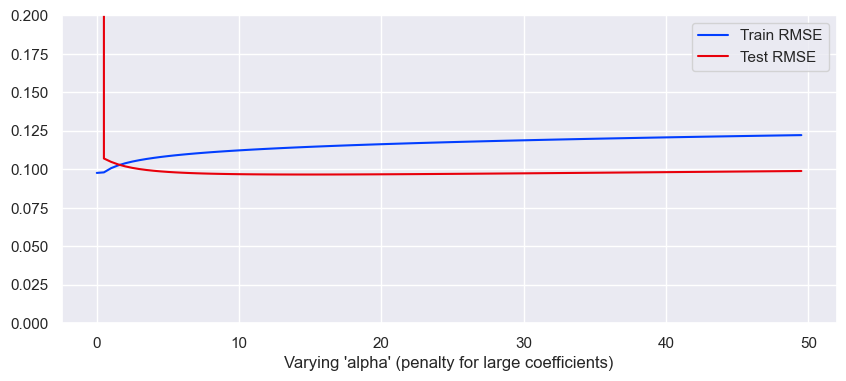

In [ ]:
# Tuning Ridge, varying alpha (strength of regularization between 0 and 50, by 0.5). Simply see the "elbow" and choose parameters - I assume this should not need explanation. A parameter chosen larger than 10 would not make much difference than 10.
train_rmse = []
test_rmse = []
grid = np.arange(0,50,0.5)

for i in grid:
    model = Ridge(alpha = i)
    train_score, test_score = tune_models(model)
    train_rmse.append(train_score)
    test_rmse.append(test_score)

fig, ax = plt.subplots(figsize=(10,4))
plot_rmse(ax,grid,train_rmse,test_rmse)
ax.set_ylim([0,0.2])
ax.set_xlabel("Varying 'alpha' (penalty for large coefficients)")
plt.legend()
plt.show()

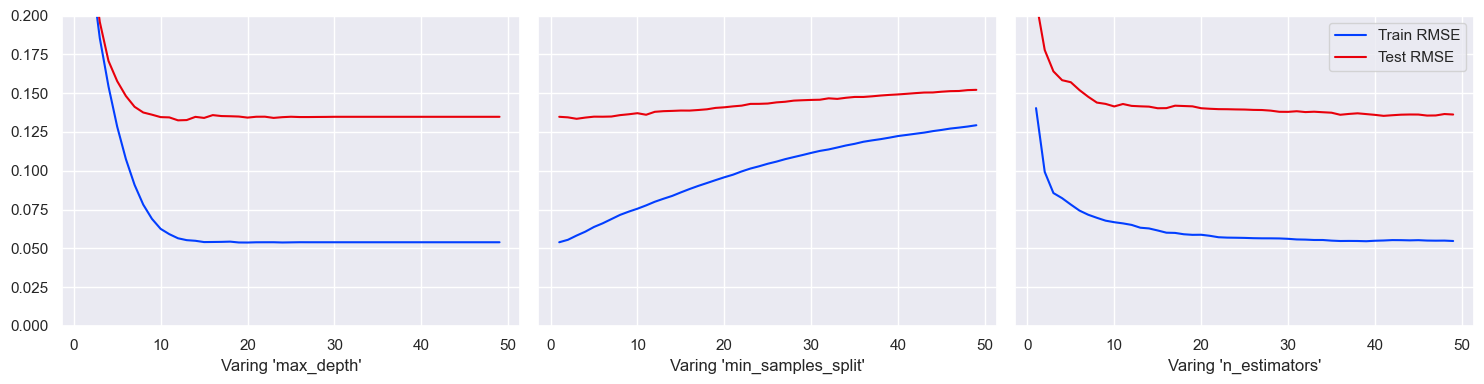

In [ ]:
# Tunning Random Forest. I need to vary three parameters, so I create 6 lists to store values, and in each interation, fit three times. Results suggest to choose 20 for 'max_depth' (tree depth), smallest value for 'min_sample_split' (smallest number requires to split the sample) and largest value for 'n_estimators' (number of trees).
train_rmse = []
test_rmse = []
train_rmse1 = []
test_rmse1 = []
train_rmse2 = []
test_rmse2 = []
grid = range(1,50)

for i in grid:
    model = RandomForestRegressor(max_depth = i, random_state = 123,n_jobs=-1)
    train_score, test_score = tune_models(model)
    train_rmse.append(train_score)
    test_rmse.append(test_score)
    
    model1 = RandomForestRegressor(min_samples_split=i+1, random_state = 123,n_jobs=-1)
    train_score1, test_score1 = tune_models(model1)
    train_rmse1.append(train_score1)
    test_rmse1.append(test_score1)
    
    model2 = RandomForestRegressor(n_estimators = i, random_state = 123,n_jobs=-1)
    train_score2, test_score2 = tune_models(model2)
    train_rmse2.append(train_score2)
    test_rmse2.append(test_score2)
    
fig, axes = plt.subplots(1,3,figsize=(15,4),sharey=True)
plot_rmse(axes[0],grid,train_rmse,test_rmse)
plot_rmse(axes[1],grid,train_rmse1,test_rmse1)
plot_rmse(axes[2],grid,train_rmse2,test_rmse2)
axes[0].set_ylim([0,0.2])
axes[0].set_xlabel("Varing 'max_depth'")
axes[1].set_xlabel("Varing 'min_samples_split'")
axes[2].set_xlabel("Varing 'n_estimators'")
plt.tight_layout()
plt.legend()
plt.show()

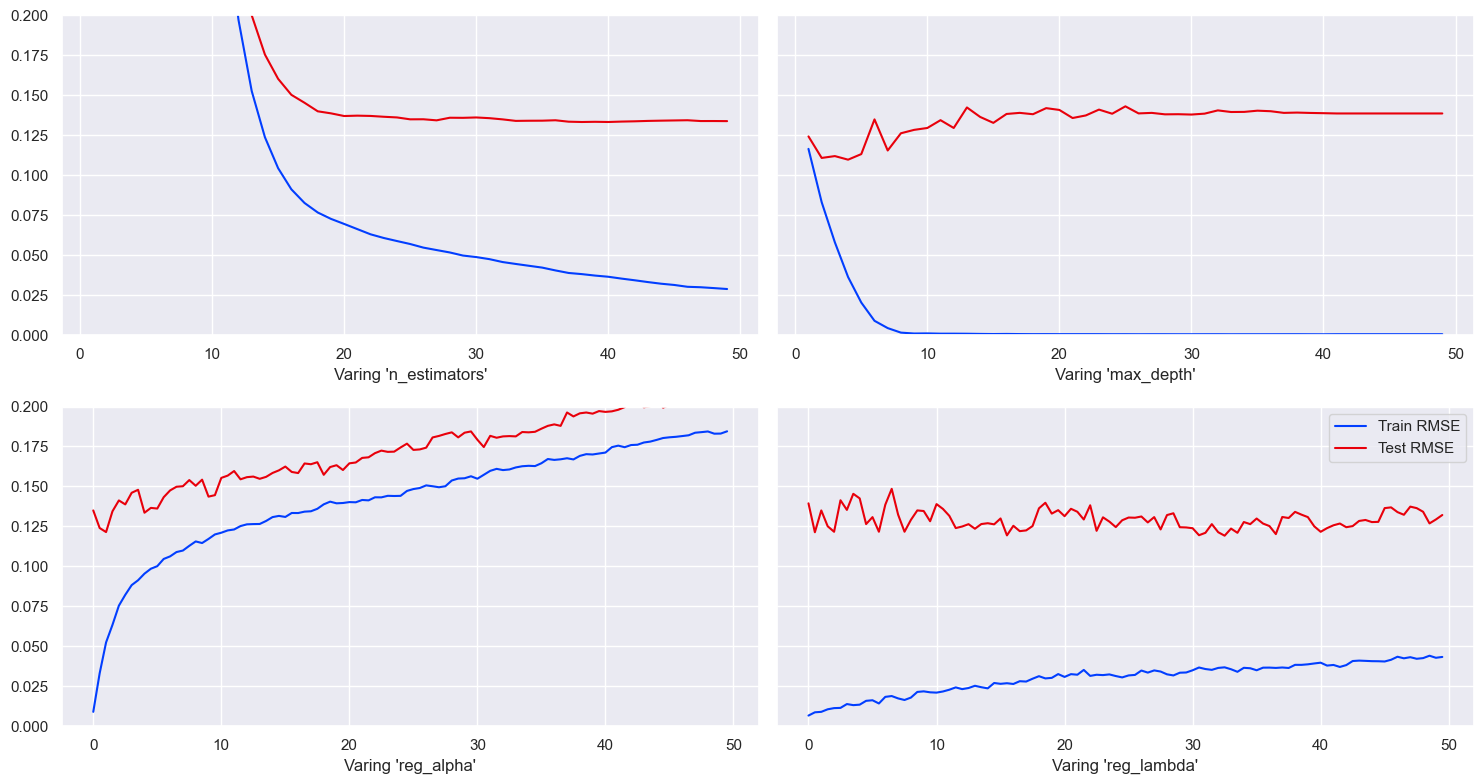

In [ ]:
# Tune XGBoost. Varying four parameters, two relating to tree depth and number of trees, and two relating to regularization strength. Repeating the previous step
train_rmse = []
test_rmse = []
train_rmse1 = []
test_rmse1 = []
train_rmse2 = []
test_rmse2 = []
train_rmse3 = []
test_rmse3 = []
grid = range(1,50)

for i in grid:
    model = XGBRegressor(n_estimators = i, objective='reg:squarederror',eval_metric='rmse',random_state = 123, n_jobs=-1)
    train_score, test_score = tune_models(model)
    train_rmse.append(train_score)
    test_rmse.append(test_score)
    
    model1 = XGBRegressor(max_depth = i, objective='reg:squarederror',eval_metric='rmse',random_state = 123, n_jobs=-1)
    train_score1, test_score1 = tune_models(model1)
    train_rmse1.append(train_score1)
    test_rmse1.append(test_score1)
    
for i in np.arange(0,50,0.5):
    model2 = XGBRegressor(reg_alpha = i, objective='reg:squarederror',eval_metric='rmse', random_state = 123, n_jobs=-1)
    train_score, test_score = tune_models(model2)
    train_rmse2.append(train_score)
    test_rmse2.append(test_score)
    
    model3 = XGBRegressor(reg_lambda = i, objective='reg:squarederror',eval_metric='rmse', random_state = 123, n_jobs=-1)
    train_score1, test_score1 = tune_models(model3)
    train_rmse3.append(train_score1)
    test_rmse3.append(test_score1)
    
fig, axes = plt.subplots(2,2,figsize=(15,8),sharey=True)
plot_rmse(axes[0,0],grid,train_rmse,test_rmse)
plot_rmse(axes[0,1],grid,train_rmse1,test_rmse1)
plot_rmse(axes[1,0],np.arange(0,50,0.5),train_rmse2,test_rmse2)
plot_rmse(axes[1,1],np.arange(0,50,0.5),train_rmse3,test_rmse3)
axes[0,0].set_ylim([0,0.2])
axes[0,0].set_xlabel("Varing 'n_estimators'")
axes[0,1].set_xlabel("Varing 'max_depth'")
axes[1,0].set_xlabel("Varing 'reg_alpha'")
axes[1,1].set_xlabel("Varing 'reg_lambda'")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Summarizing previous hyperparameter tunning results, choosing the best parameters
model_Ridge = Ridge(alpha = 30)
model_RandomForest = RandomForestRegressor(max_depth = 20, min_samples_split=5, n_estimators = 100, random_state = 123,n_jobs=-1)
model_XGBoost = XGBRegressor(n_estimators = 100, max_depth = 3, reg_alpha = 0, reg_lambda = 0, objective='reg:squarederror',eval_metric='rmse', random_state = 123, n_jobs=-1)

for key,model in {"Ridge":model_Ridge, "Random Forest": model_RandomForest, "XGBoost": model_XGBoost}.items():
    model.fit(X_train,y_train)
    rmse = np.sqrt(mean_squared_error(y_test,model.predict(X_test)))
    print("The RMSE of hyperparameter tunned final {} model is {}.\n".format(key,rmse))

The RMSE of hyperparameter tunned final Ridge model is 0.09730059178565599.

The RMSE of hyperparameter tunned final Random Forest model is 0.13397475098465378.

The RMSE of hyperparameter tunned final XGBoost model is 0.11715158225631124.



### Examining Model Result Generalization
It might be possible that a model yield good results just for a particular sample. We have been discussing this repeatedly in the econometric courses, and Bayesian Estimations are based on some ideas of that. Cross validation is a way to check if a model result can generalize, however, I prefer bootstrapping a large number of samples. It essentially makes little difference with cross validation. Cross validation uses distinct data, but since after each bootstrapping, the model is estimated again and does not use previous data to update, there is no training data leakage concerns here.
  
The simulation results show `XGBoost` is better than `Random Forest`, having more smaller RMSE, and `Ridge` is better than `XGBoost`. But `Ridge` is the most unstable one. It has some proportions of unfavorable results. The reason might be the simplicity of the model and prone to outliers.

Intriguing yet perplexing, `Ridge` has most smaller RMSE values, but it is the simplist model. Later after I submit the predictions, Ridge also has the best score among the four on the test data.

Some students might ask, why wouldn't we use the predictors that have the lowest socore for any other datasets? We should know that for each dataset, the algorithm optimizes the model predictions, so the scores below show the best score attainable for each sample. So if you use predictors in stead of models, it can only yield equal or worse performance.

In [ ]:
# Use scikit learn's train_test_split to randomly give 500 different splits, and fit models, producing predictions and scores.
rmse_comparision = {'Ridge': [], 'Random Forest': [], 'XGBoost': []}
for i in range(1,500):
    X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size = 0.1,random_state = i)
    for key,model in {"Ridge":model_Ridge, "Random Forest": model_RandomForest, "XGBoost": model_XGBoost}.items():
        model.fit(X_train,y_train)
        rmse = np.sqrt(mean_squared_error(y_test,model.predict(X_test)))
        rmse_comparision[key].append(rmse)

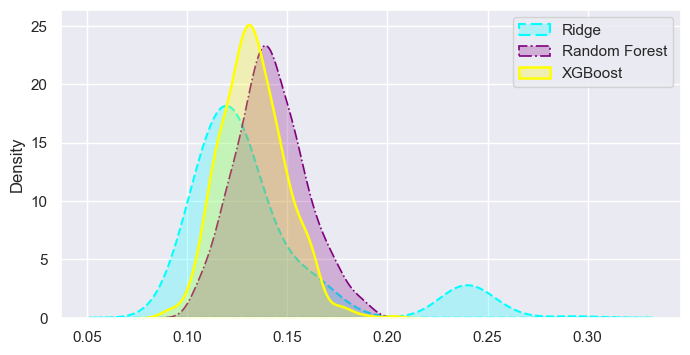

In [ ]:
# Kernel density estimate plot each 500 scores by each model
fig,ax = plt.subplots(figsize = (8,4))
sns.kdeplot(rmse_comparision['Ridge'],color = 'Cyan', linewidth = 1.5,linestyle = '--',label = 'Ridge',shade= True)
sns.kdeplot(rmse_comparision['Random Forest'],color = 'Purple', linewidth = 1.2,label = 'Random Forest',linestyle = '-.',shade= True)
sns.kdeplot(rmse_comparision['XGBoost'],color = 'Yellow', linewidth = 1.8,label = 'XGBoost',shade= True)
plt.legend()
plt.show()

### Feature Importances from XGBoost
An advantage of tree-based models and ensemble models is that they can display feature importances - ranking the most important features contributing to predicting to the least important ones. The method is associated with model object. Call it, store values and display in a bar plot.

In [ ]:
strings = list(strings) 
strings.append('MSSubClass') # Previously I convert this numeric to categorical, but does not update the string variable name list. Now I update it

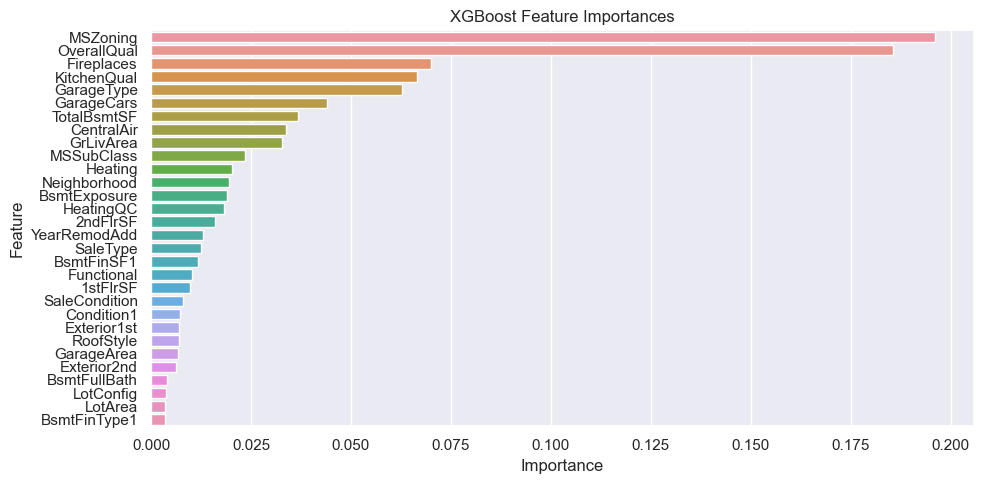

In [ ]:
# Now this is one important step. Previously I created dummy variables, so each cateogry is disembled from the categorical variable it belongs to. They have to be mapped back and assemble the original categorical variables, by summing each individual feature importance.
# This part looks simple but shows off programming ability

feature_importances = model_XGBoost.feature_importances_ # Simply use the method associated with the model
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}) # Creating a dataframe for plotting

category_remap = {} # Creating a dictionary for remapping
for i in strings:
    if feature_importance_df['Feature'].str.contains(i).any():# I use string method, because pd.dummies creates prefix using the name of the original column.
        category_remap[i] = feature_importance_df[feature_importance_df['Feature'].str.contains(i)]['Importance'].sum() 

# And convert the dictionary to dataframe
category_imp = pd.DataFrame.from_dict(category_remap, orient='index', columns=['Importance'])
category_imp = category_imp.reset_index()
category_imp.columns = ['Feature','Importance']

num_imp = feature_importance_df[~feature_importance_df['Feature'].str.contains('_')] # string method, remove dummy variables, keeping only numeric variable
importances = pd.concat([num_imp,category_imp], axis = 0) # concat remapped categorical variable and numeric variable
importances = importances[(importances != 0).all(axis=1)]
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(y=importances['Feature'][0:30], x=importances['Importance'][0:30])
plt.xticks()
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.tight_layout()

## Deep Learning: Unveiling Neural Networks
One of the best thing about advancement in machine learning, deep learning, AI, and computer science is that, people can easily do complex things. I've spent too much time on previous machine learning models, but since there are brilliant packages providing simple codes for building deep learning models, it does not hurt at all to spend a bit more time on this one. I apply Keras packages, and quickly build a model with three hidden layers.

One advantage of deep learning model is that you don't necessarily need feature engineering - neural networks creates them. However, in this report, neural works perform better when feature engineering is applied. The following model operates on the same data as other models. The neural networks model is also selected to make final predictions.

In [ ]:
# A neural networks model
tf.random.set_seed(123)
ncols = X_train.shape[1]
model = Sequential()
model.add(Dense(100,input_shape=(ncols,),activation = 'relu'))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(50,activation = 'relu'))
model.add(Dense(20,activation = 'relu'))
model.add(Dense(5,activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer="adam" , loss="mse")
history = model.fit(X_train,y_train,epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
42/42 [==============================] - 1s 5ms/step - loss: 74.2112 - val_loss: 0.3993
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 1.0919 - val_loss: 0.1464
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 0.1549 - val_loss: 0.1025
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0914 - val_loss: 0.0753
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0632
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0451
Epoch 8/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0408
Epoch 9/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0382
Epoch 10/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0333
Epoch 11

5/5 [==============================] - 0s 1ms/step
RMSE of the neural network model is 0.16351898791425556 



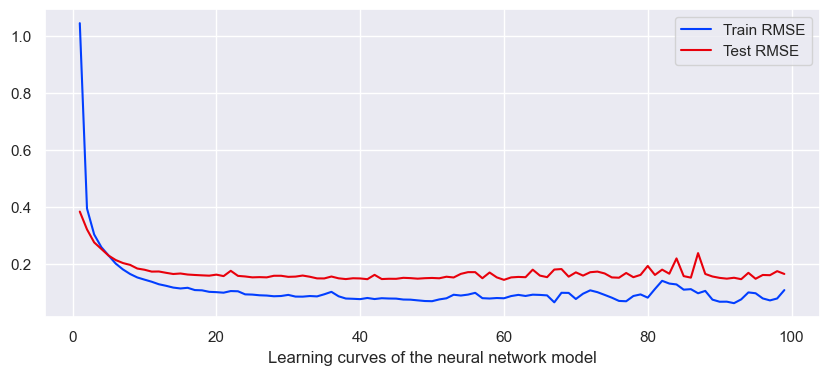

In [ ]:
# Error curves. It seems the model does not improve after 40 epochs. However, I don't intend to improve. I've spent too much time on this assignment.
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
print('RMSE of the neural network model is {}'.format(rmse),'\n')

loss = np.sqrt(history.history['loss'][1:])
val_loss = np.sqrt(history.history['val_loss'][1:])
epochs = range(1, len(loss)+1)

fig, ax = plt.subplots(figsize=(10,4))
plot_rmse(ax,epochs,loss,val_loss)
ax.set_xlabel("Learning curves of the neural network model")
plt.legend()
plt.show()

### Final Predictions, Submissions and Some Reflections
The last thing to do is using all chosen models to make predictions on the test dataset, and submit them. As of August 15, 2023, my best score ranks 921 among 4200 submissions. This is not bad, really not bad at all, given that I am working alone, and I haven't started meticulous feature extractions and engineering yet. One thing need to notice is that if I lower the RMSE to around 0.1, I am in top 100. In the early generations of the models in this report, performace generally scatter around 0.16 - 0.2, and after the current scheme of feature engineering (not very complex though), performance improves to 0.13. This suggests better schemes are necessary for improving model accuracy.
  
However, in top 100, RMSE improves like exponetially. The top 10 have RMSE lower than 0.001. This suggests their models are already incredily accurate. One very positive aspect of these online machine learning competitions is that, people tend to share their work, so people can discuss and learn from each other. This leads the future path of my learning journey. I haven't checked their codes yet, and I don't intend to it recently. I've spent too much time on this, but I really enjoy it, and I indeed learn a lot.
  
Another very strong positive aspect of Python programming and machine learning in general is that, it's open source, and the community is very active. This field evolves so fast and keeps improving continuously, and there's very large positive spillover effect. There are so many learning material online, good and free. Imagine before I started this master, I could only use Stata, an old school econometrics software. Now I know a lot about Python (besides R and SQL) and machine learning. I can build several models. I am very happy about that, and this would definitely not be the end of the learning journey even though I will graduate very soon.

In [ ]:
pred1 = model_Ridge.predict(predict_data)
pred2 = model_RandomForest.predict(predict_data)
pred3 = model_XGBoost.predict(predict_data)
pred4 = model.predict(predict_data)
pred1 = np.exp(pred1)
pred2 = np.exp(pred2)
pred3 = np.exp(pred3)
pred4 = np.exp(pred4)

46/46 [==============================] - 0s 781us/step


In [ ]:
results1 = 'Ridge.csv'
results2 = 'RF.csv'
results3 = 'XGB.csv'
results4 = 'keras.csv'

submission1 = pd.DataFrame({
        "Id": range(1461, 2920),
        "SalePrice": pred1.reshape(-1)

    })
submission1.to_csv(results1, index = False)

submission2 = pd.DataFrame({
        "Id": range(1461, 2920),
        "SalePrice": pred2.reshape(-1)

    })
submission2.to_csv(results2, index = False)

submission3 = pd.DataFrame({
        "Id": range(1461, 2920),
        "SalePrice": pred3.reshape(-1)

    })
submission3.to_csv(results3, index = False)

submission4 = pd.DataFrame({
        "Id": range(1461, 2920),
        "SalePrice": pred4.reshape(-1)

    })
submission4.to_csv(results4, index = False)

![Screenshot 2023-08-15 202435](Screenshot%202023-08-15%20202435.jpg)


## Conclusion
The final outcomes, along with the comprehensive model construction journey and insights gained from other projects on the same topic, collectively confirm what Andrew Ng has said - applied machine learning is basically feature engineering. It becomes evident that feature engineering, including the process of transforming and extracting features, substantially contributes to the enhancement of the model's performance. Moving forward, it is crucial to concentrate on advancing this facet for further improvement. Additionally, the technique of model stacking stands out as a practical and promising approach worth considering.

## References

Huntington-Klein, N. (2021). The effect: An introduction to research design and causality. CRC Press.

Kuhn, M., & Johnson, K. (2013). Applied predictive modeling (Vol. 26, p. 13). New York: Springer.

### _Thank you very much for reading! Bye!_